<a href="https://colab.research.google.com/github/Asfilcnx3/Project9_Flowers102/blob/main/Flowers102_Proyecto9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Vamos a Trabajar un proyecto más de clasificación, esta vez será "Flowers102" con "IMAGENET1K_V2"
* Esta vez cargaremos el dataset directo desde `torchvision.datasets`

In [ ]:
# Importamos todas las librerias
import torch
import torch.nn as nn
import torch.optim as optim
import torch.backends.cudnn as cudnn # la aceleración GPU
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import seaborn as sns
from os import path
import json
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from torch.optim.lr_scheduler import StepLR

cudnn.benchmark = True # con esto encontramos los mejores algoritmos para el uso de "Cuda"

-
* Existen diferentes tipos de código para hacer data aumentation, vamos a utilizar:

1. RandomHorizontalFlip()
2. RandomRotation() -> ángulos pequeños
3. ColorJitter() -
4. RandomErasing()
5. RandomResizedCrop()


-
* **Y las obligatorias:**

1. CenterCrop()
2. Resize()
3. ToTensor()
4. Normalize()

In [ ]:
# Vamos a crear las funciones necesarias para cargar y normalizar los datos

torch_transform = transforms.Compose([ # Esto es necesario ya que el set de prueba solo cuenta con 1020 datos para su entrenamiento
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3), value=0, inplace=False),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

image_dataset = {
    "train": datasets.Flowers102(root="./data", split="train", download=True, transform=torch_transform),
    "val": datasets.Flowers102(root="./data", split="val", download=True, transform=val_transform)
}
test_data = datasets.Flowers102(root="./data", split="test", download=True, transform=val_transform)


dataloaders = {
    "train": torch.utils.data.DataLoader(image_dataset["train"], batch_size=32, shuffle=True, num_workers=2),
    "val": torch.utils.data.DataLoader(image_dataset["val"], batch_size=32, shuffle=False, num_workers=2)
}
test_loader = torch.utils.data.DataLoader(test_data, batch_size=32, shuffle=True, num_workers=2)


# Usaremos el acelerador de cuda
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using the device: {device}")

100%|██████████| 345M/345M [00:01<00:00, 206MB/s]
100%|██████████| 502/502 [00:00<00:00, 1.55MB/s]
100%|██████████| 15.0k/15.0k [00:00<00:00, 14.0MB/s]

Using the device: cuda


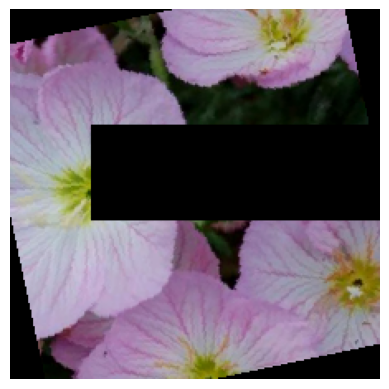

In [ ]:
# Vamos a visualizar la foto "original" pero NO SE VERÁ LO BORRADO POR:
# transforms.RandomErasing()

def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    plt.axis("off")
    if title is not None:
        plt.title(title)
    plt.pause(0.001)


# tomamos una parte de los datos (input -> imagen, label -> etiqueta)
input, label = next(iter(image_dataset["train"]))

out = torchvision.utils.make_grid(input) # Hacemos que las imagenes tengan la forma correcta para visualizarlo
imshow(out) # ejecutamos la función anterior

In [ ]:
# Definimos el ciclo de entrenamiento
def train_model(model, loss_fn, optimizer, scheduler, patience, num_epochs=25):
  best_acc = 0.0
  counter = 0
  best_val_loss = float('inf')

  # Definimos las 3 variables con las que vamos a visualizar los datos
  train_losses = []
  val_losses = []
  val_accs = []

  for epoch in range(num_epochs):
    print("-----"*10)

    # Cada época tendrá su fase de validación y de entrenamiento
    for phase in ["train", "val"]:
      if phase == "train":
        model.train()
      else:
        model.eval()

      running_loss = 0.0
      all_preds = []
      all_labels = []

      # Iteramos sobre todos los datos
      for images, labels in dataloaders[phase]:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()

        with torch.set_grad_enabled(phase == "train"):
          outputs = model(images)
          loss = loss_fn(outputs, labels)

          if phase == "train":
            loss.backward()
            optimizer.step()

        running_loss += loss.item() * images.size(0)


        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

      epoch_loss = running_loss / len(image_dataset[phase])
      epoch_acc = accuracy_score(all_labels, all_preds)

      if phase == "train":
        train_losses.append(running_loss / len(image_dataset["train"]))
        scheduler.step()
      else:
        val_losses.append(epoch_loss)
        val_accs.append(epoch_acc)

        if val_losses[-1] < best_val_loss:
          best_val_loss = val_losses[-1]
          counter = 0
          torch.save(model.state_dict(), "flowers102_best_model.pt")

        else:
          counter += 1
          if counter >= patience:
            print(f"Early stopping saved on epoch: {epoch-patience}")
            model.load_state_dict(torch.load("flowers102_best_model.pt"))
            return model, train_losses, val_losses, val_accs, all_preds, all_labels

      if phase == "val":
        print(f"Epoch: {epoch+1}/{num_epochs}")
        print(f"Train Loss: {train_losses[-1]:.3f}")
        if val_losses and val_accs:
          print(f"Val Loss: {val_losses[-1]:.3f}, Val Acc: {val_accs[-1] * 100:.2f}%")
        else:
          print("Validation metrics not available")

  model.load_state_dict(torch.load("flowers102_best_model.pt"))
  return model, train_losses, val_losses, val_accs, all_preds, all_labels

In [ ]:
def visualize_graphics_vs_graphics(train1, val1, accs1, train2, val2, accs2):
  plt.figure(figsize=(12, 6))
  plt.subplot(1, 2, 1)
  plt.plot(train1, label="Train Loss", color= "teal")
  plt.plot(val1, label="Val Loss", color="c")
  plt.plot(accs1, label="Val Accuracy", color = "aqua")
  plt.title("Train Loss Vs Val Acc vs Val Loss")
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.legend()


  plt.subplot(1, 2, 2)
  plt.plot(train2, label="Train Loss", color="plum")
  plt.plot(val2, label="Val Loss", color="darkmagenta")
  plt.plot(accs2, label="Val Accuracy", color="orchid")
  plt.title("Train Loss Vs Val Acc vs Val Loss")
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.legend()
  plt.show()

## Provaremos como en la anterior, con finetuning y congelando los pesos (fixed feature extractor)

In [ ]:
# Empezamos con finetuning
# Definimos el modelo
model_ft = models.resnet50(weights="IMAGENET1K_V2")
num_ftrs = model_ft.fc.in_features

# Aumentamos las capas de salida por la cantidad de categorías
model_ft.fc = nn.Linear(num_ftrs, 102)
model_ft.to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer_ft = optim.AdamW(model_ft.parameters(), lr=0.001)

lr_scheduler = StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [ ]:
# Entrenamos
model_ft, train_losses_ft, val_losses_ft, val_accs_ft, all_preds_ft, all_labels_ft = train_model(
    model_ft,
    loss_fn,
    optimizer_ft,
    lr_scheduler,
    patience=7,
    num_epochs=50
)

# Epoch: 19/30
# Train Loss: 0.168, Train Acc: 91.86%
# Val Loss: 0.391, Val Acc: 91.86%

--------------------------------------------------
Epoch: 1/50
Train Loss: 4.179
Val Loss: 3.106, Val Acc: 28.92%
--------------------------------------------------
Epoch: 2/50
Train Loss: 2.480
Val Loss: 1.953, Val Acc: 46.96%
--------------------------------------------------
Epoch: 3/50
Train Loss: 1.655
Val Loss: 1.936, Val Acc: 53.04%
--------------------------------------------------
Epoch: 4/50
Train Loss: 1.235
Val Loss: 1.546, Val Acc: 61.76%
--------------------------------------------------
Epoch: 5/50
Train Loss: 1.070
Val Loss: 1.204, Val Acc: 68.24%
--------------------------------------------------
Epoch: 6/50
Train Loss: 0.795
Val Loss: 1.169, Val Acc: 72.84%
--------------------------------------------------
Epoch: 7/50
Train Loss: 0.714
Val Loss: 0.966, Val Acc: 76.47%
--------------------------------------------------
Epoch: 8/50
Train Loss: 0.505
Val Loss: 0.512, Val Acc: 86.18%
--------------------------------------------------
Epoch: 9/50
Train Loss: 0.382
Val Los

In [ ]:
# Ahora el modelo fixed feature extractor
#Ahora el model fixed feature extractor

model_conv = torchvision.models.resnet50(weights="IMAGENET1K_V2")
for param in model_conv.parameters():
  param.requires_grad = False  # Para que no se mejore

num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 102)
model_conv.to(device)

optimizer_conv = optim.AdamW(model_conv.fc.parameters(), lr=0.001)
lr_scheduler_conv = StepLR(optimizer_ft, step_size=7, gamma=0.1)
# Usaremos la misma función de perdida

In [ ]:
# Entrenamos este modelo
model_conv, train_losses_conv, val_losses_conv, val_accs_conv, all_preds_conv, all_labels_conv = train_model(
    model_conv,
    loss_fn,
    optimizer_conv,
    lr_scheduler_conv,
    patience=7,
    num_epochs=50
)

# Epoch: 30/30
# Train Loss: 0.510, Train Acc: 85.88%
# Val Loss: 0.787, Val Acc: 85.88%

--------------------------------------------------
Epoch: 1/50
Train Loss: 4.480
Val Loss: 3.985, Val Acc: 45.69%
--------------------------------------------------
Epoch: 2/50
Train Loss: 3.689
Val Loss: 3.433, Val Acc: 62.55%
--------------------------------------------------
Epoch: 3/50
Train Loss: 3.131
Val Loss: 2.993, Val Acc: 69.31%
--------------------------------------------------
Epoch: 4/50
Train Loss: 2.693
Val Loss: 2.647, Val Acc: 72.55%
--------------------------------------------------
Epoch: 5/50
Train Loss: 2.321
Val Loss: 2.370, Val Acc: 75.49%
--------------------------------------------------
Epoch: 6/50
Train Loss: 2.070
Val Loss: 2.159, Val Acc: 76.76%
--------------------------------------------------
Epoch: 7/50
Train Loss: 1.896
Val Loss: 1.985, Val Acc: 77.35%
--------------------------------------------------
Epoch: 8/50
Train Loss: 1.634
Val Loss: 1.785, Val Acc: 79.51%
--------------------------------------------------
Epoch: 9/50
Train Loss: 1.510
Val Los

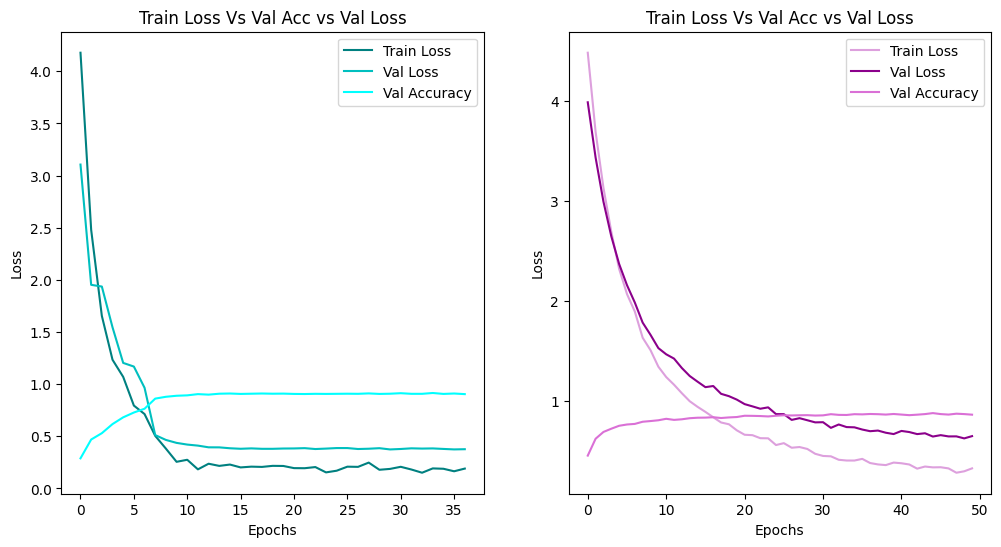

In [ ]:
visualize_graphics_vs_graphics(
    train_losses_ft,
    val_losses_ft,
    val_accs_ft,
    train_losses_conv,
    val_losses_conv,
    val_accs_conv
)

In [ ]:
# Creamos una función para evaluar los modelos
def evaluate_model(model, dataloader, loss_fn, device):
  model.eval()
  test_loss = 0.0
  y_true, y_pred = [], []
  correct = 0

  with torch.no_grad():
    for images, labels in dataloader:
      images, labels = images.to(device), labels.to(device)
      outputs = model(images)
      loss = loss_fn(outputs, labels)
      test_loss += loss.item() * images.size(0)

      preds = outputs.argmax(dim=1)
      correct += (preds == labels).sum().item()
      y_true.extend(labels.cpu().numpy())
      y_pred.extend(preds.cpu().numpy())

  avg_loss = test_loss / len(dataloader.dataset)
  accuracy = correct / len(dataloader.dataset)
  return avg_loss, accuracy, y_true, y_pred

In [ ]:
# Comparamos sus métricas principales

loss_ft, acc_ft, true_ft, pred_ft = evaluate_model(model_ft, test_loader, loss_fn, device)
loss_conv, acc_conv, true_conv, pred_conv = evaluate_model(model_conv, test_loader, loss_fn, device)

print("Comparación de ambos modelos")
print(f"Fine Tuning: Loss: {loss_ft:.3f}, Accuracy: {acc_ft * 100:.2f}%")
print("====" * 15)
print(f"Feature Extractor: Loss: {loss_conv:.3f}, Accuracy: {acc_conv * 100:.2f}%")
print("-----" * 15)

Comparación de ambos modelos
Fine Tuning: Loss: 0.490, Accuracy: 87.79%
Feature Extractor: Loss: 0.675, Accuracy: 85.97%
---------------------------------------------------------------------------


== Fine Tuning ==
              precision    recall  f1-score   support

           0       0.63      0.95      0.76        20
           1       0.94      0.85      0.89        40
           2       0.52      0.70      0.60        20
           3       0.68      0.58      0.63        36
           4       0.97      0.87      0.92        45
           5       1.00      0.84      0.91        25
           6       0.76      0.95      0.84        20
           7       0.89      1.00      0.94        65
           8       0.89      0.92      0.91        26
           9       0.95      0.72      0.82        25
          10       0.98      0.64      0.77        67
          11       0.97      0.87      0.91        67
          12       0.88      0.97      0.92        29
          13       0.76      1.00      0.86        28
          14       0.83      1.00      0.91        29
          15       0.73      0.90      0.81        21
          16       1.00      0.98      0.99        65
         

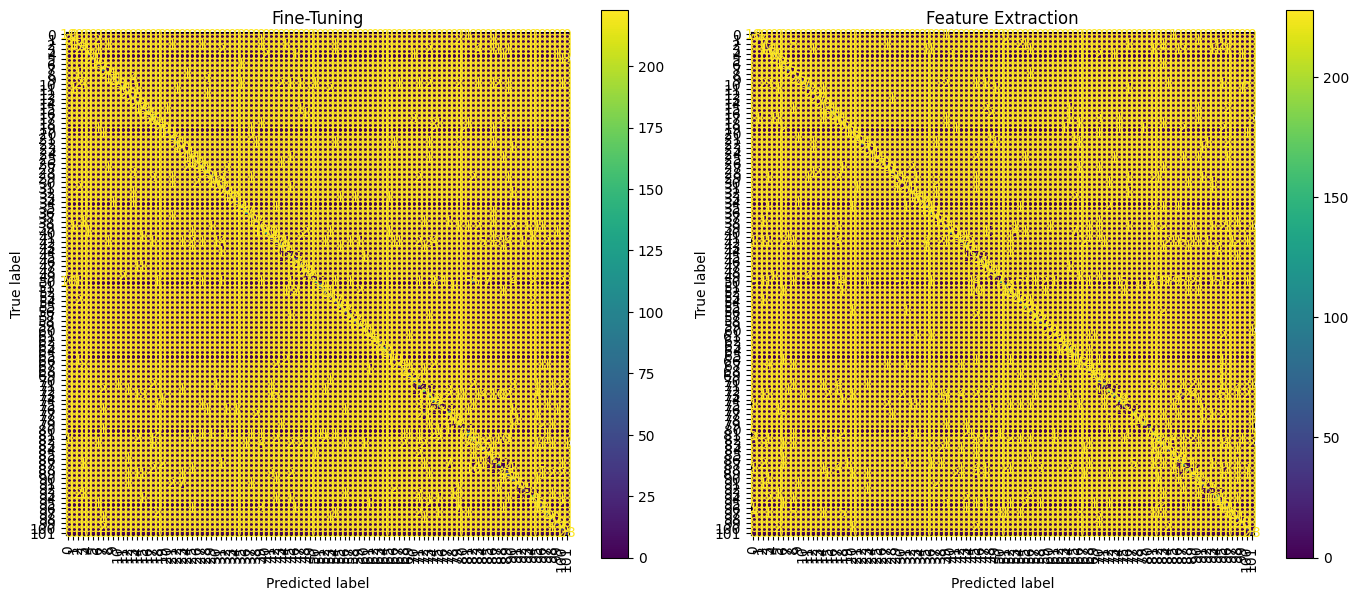

In [ ]:
# Reporte de clasificación
print("== Fine Tuning ==")
print(classification_report(true_ft, pred_ft))
print("== Feature Extraction ==")
print(classification_report(true_conv, pred_conv))

# Matriz de confusión
cm_ft = confusion_matrix(true_ft, pred_ft)
cm_conv = confusion_matrix(true_conv, pred_conv)

fig, axs = plt.subplots(1, 2, figsize=(14, 6))

disp1 = ConfusionMatrixDisplay(confusion_matrix=cm_ft)
disp1.plot(ax=axs[0], xticks_rotation="vertical", values_format='d')
axs[0].set_title("Fine-Tuning")

disp2 = ConfusionMatrixDisplay(confusion_matrix=cm_conv)
disp2.plot(ax=axs[1], xticks_rotation="vertical", values_format='d')
axs[1].set_title("Feature Extraction")

plt.tight_layout()
plt.show()